In [1]:
!rm -rf /root/.config/Google/DriveFS

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import resample
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm, laplace, cauchy, t, gamma, beta, logistic, uniform, ks_2samp, ks_1samp, shapiro, anderson
import torch
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import json
from datetime import datetime

In [4]:
x_train_path= '/content/drive/MyDrive/PHM2024/Dataset/TrainingDataset/X_train.csv'
y_train_path= '/content/drive/MyDrive/PHM2024/Dataset/TrainingDataset/y_train.csv'

x_train = pd.read_csv(x_train_path)
y_train = pd.read_csv(y_train_path)

x_train.info()
y_train.info()

feat_eng_path = '/content/drive/MyDrive/PHM2024/Output/FeatureEngineer'
os.makedirs(feat_eng_path, exist_ok=True)
regression_path = '/content/drive/MyDrive/PHM2024/Output/Regression'
os.makedirs(regression_path, exist_ok=True)
classification_path = '/content/drive/MyDrive/PHM2024/Output/Classification'
os.makedirs(classification_path, exist_ok=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            742625 non-null  int64  
 1   trq_measured  742625 non-null  float64
 2   oat           742625 non-null  float64
 3   mgt           742625 non-null  float64
 4   pa            742625 non-null  float64
 5   ias           742625 non-null  float64
 6   np            742625 non-null  float64
 7   ng            742625 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 45.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          742625 non-null  int64  
 1   faulty      742625 non-null  int64  
 2   trq_margin  742625 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 17.0 MB


In [5]:
merged_dataset = pd.merge(x_train, y_train, on='id')

merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            742625 non-null  int64  
 1   trq_measured  742625 non-null  float64
 2   oat           742625 non-null  float64
 3   mgt           742625 non-null  float64
 4   pa            742625 non-null  float64
 5   ias           742625 non-null  float64
 6   np            742625 non-null  float64
 7   ng            742625 non-null  float64
 8   faulty        742625 non-null  int64  
 9   trq_margin    742625 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 56.7 MB


In [6]:
# Calcolo del torque target per ogni riga
merged_dataset['trq_target'] = merged_dataset['trq_measured']/(1 + merged_dataset['trq_margin'] / 100)

# Calcolo feature derivate
merged_dataset['delta_T_relative'] = (merged_dataset['mgt'] - merged_dataset['oat']) / merged_dataset['mgt']
merged_dataset['omega'] = merged_dataset['np'] / merged_dataset['trq_measured']
merged_dataset['np_ng_ratio'] = merged_dataset['np'] / merged_dataset['ng']

merged_dataset.info()

#merged_dataset.to_csv('merged_dataset_trq_target.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                742625 non-null  int64  
 1   trq_measured      742625 non-null  float64
 2   oat               742625 non-null  float64
 3   mgt               742625 non-null  float64
 4   pa                742625 non-null  float64
 5   ias               742625 non-null  float64
 6   np                742625 non-null  float64
 7   ng                742625 non-null  float64
 8   faulty            742625 non-null  int64  
 9   trq_margin        742625 non-null  float64
 10  trq_target        742625 non-null  float64
 11  delta_T_relative  742625 non-null  float64
 12  omega             742625 non-null  float64
 13  np_ng_ratio       742625 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 79.3 MB


<ipython-input-7-8b1d35b6b0ac>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='trq_measured', palette='muted')


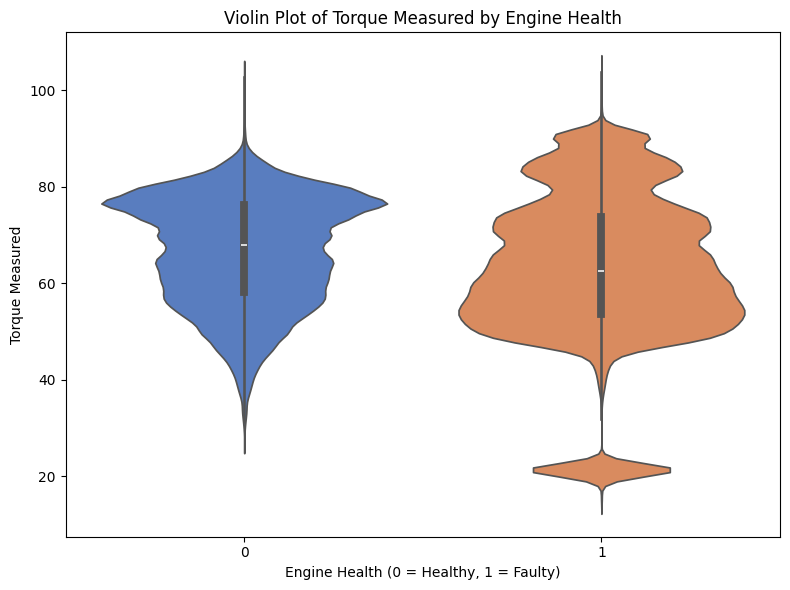

<ipython-input-7-8b1d35b6b0ac>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='oat', palette='muted')


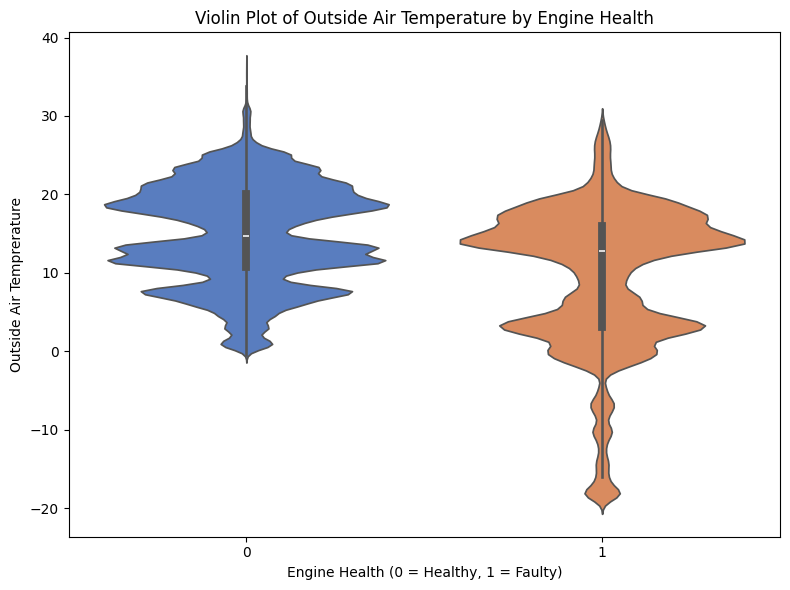

<ipython-input-7-8b1d35b6b0ac>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='mgt', palette='muted')


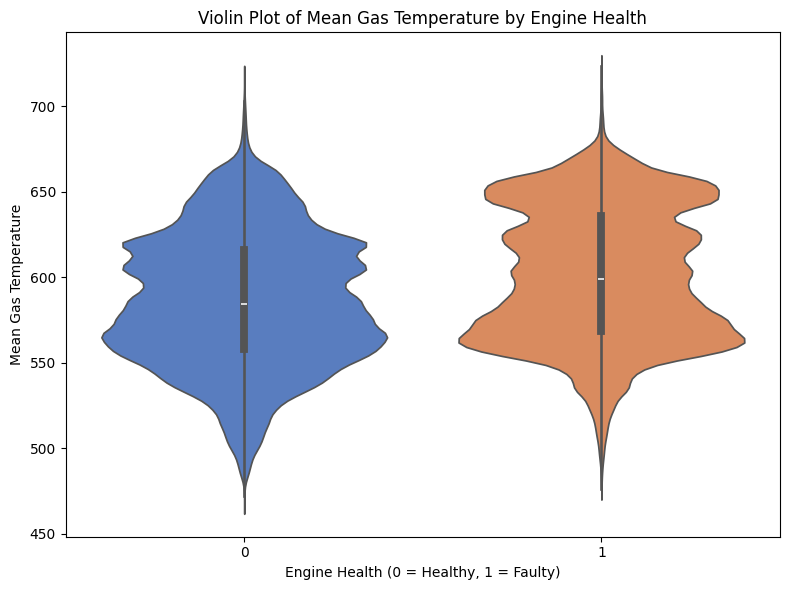

<ipython-input-7-8b1d35b6b0ac>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='pa', palette='muted')


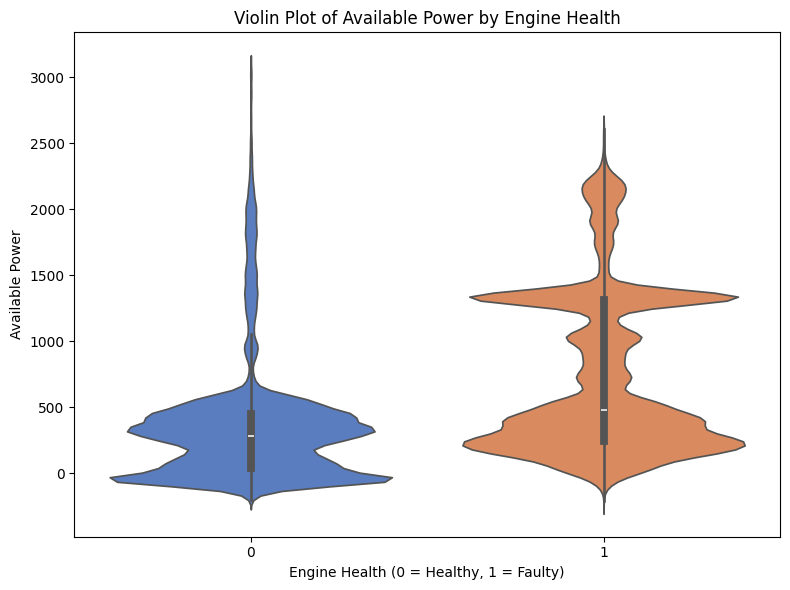

<ipython-input-7-8b1d35b6b0ac>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='ias', palette='muted')


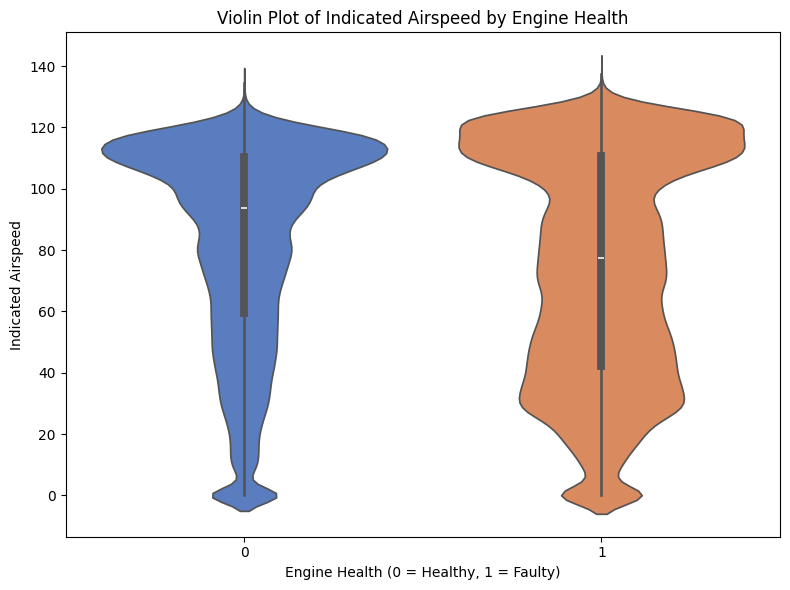

<ipython-input-7-8b1d35b6b0ac>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='np', palette='muted')


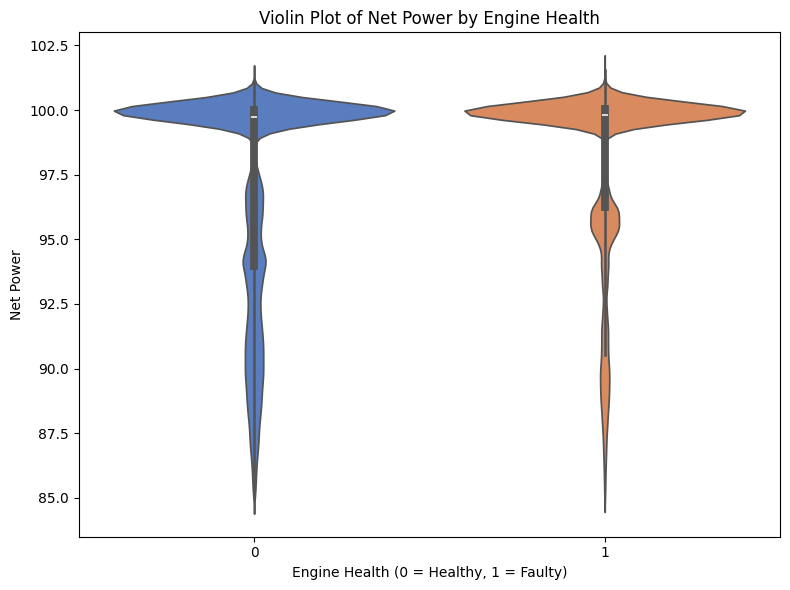

<ipython-input-7-8b1d35b6b0ac>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='ng', palette='muted')


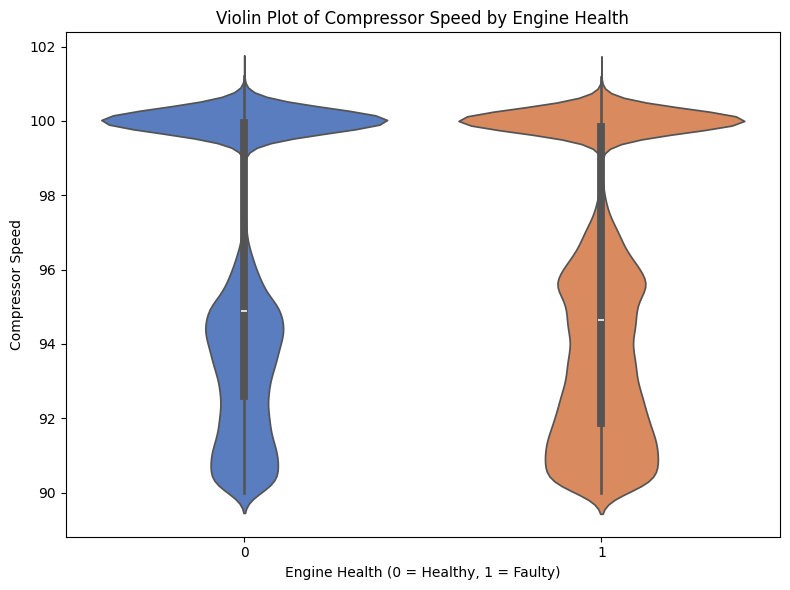

<ipython-input-7-8b1d35b6b0ac>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='trq_margin', palette='muted')


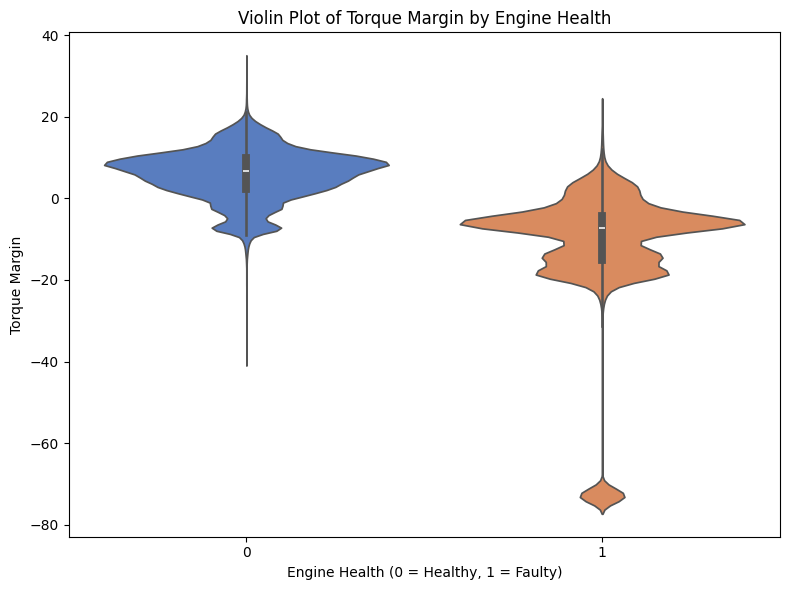

<ipython-input-7-8b1d35b6b0ac>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='trq_target', palette='muted')


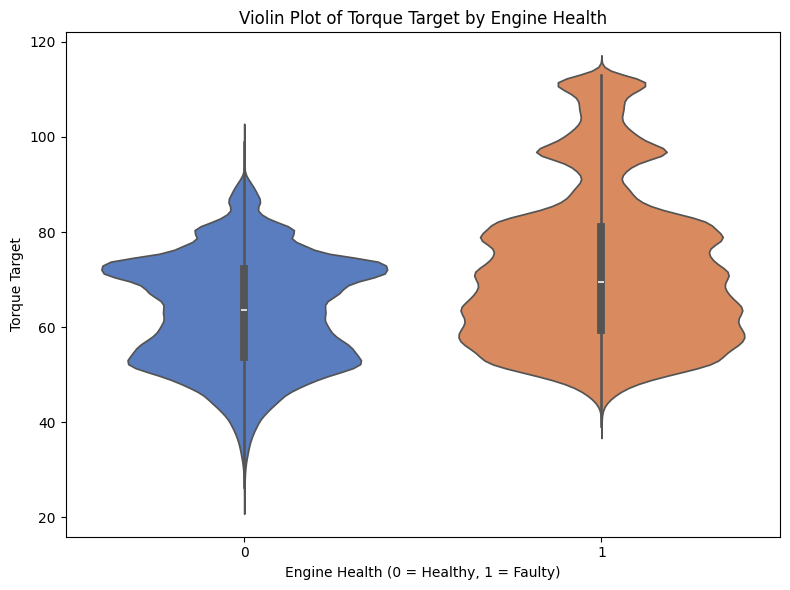

<ipython-input-7-8b1d35b6b0ac>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='delta_T_relative', palette='muted')


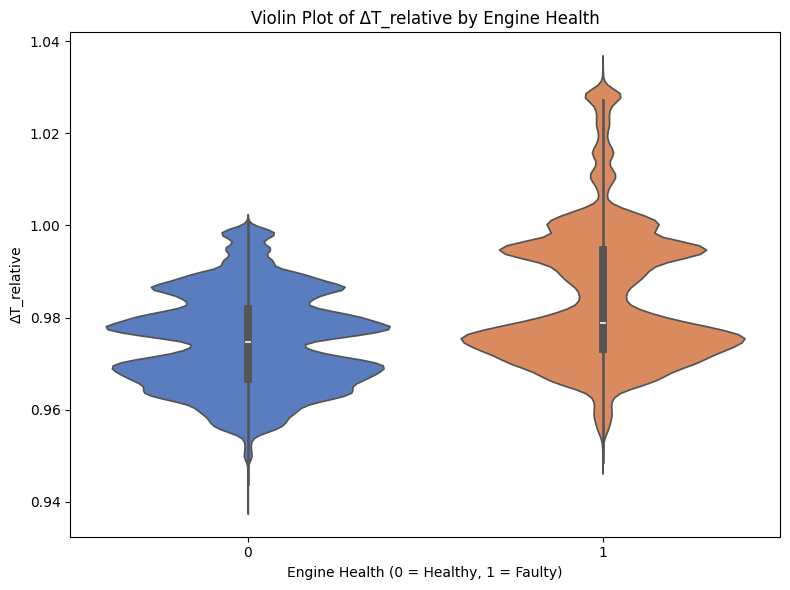

<ipython-input-7-8b1d35b6b0ac>:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='omega', palette='muted')


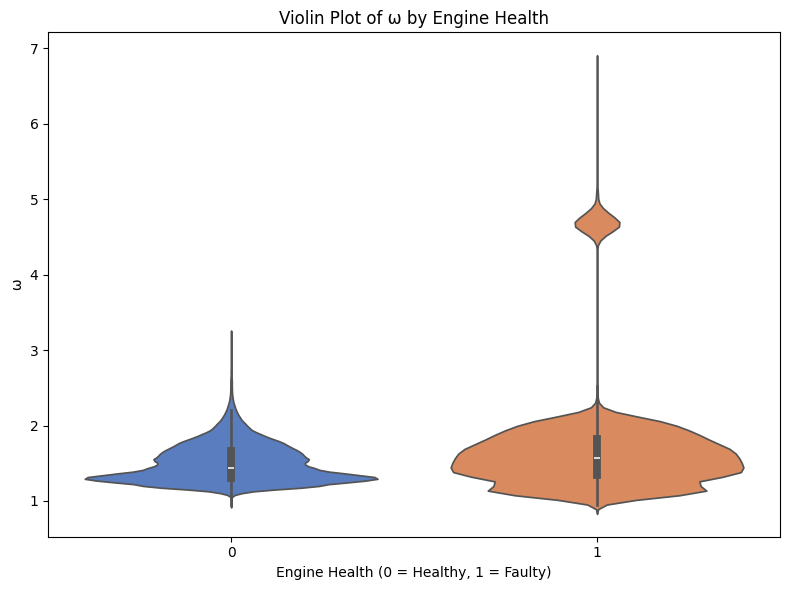

<ipython-input-7-8b1d35b6b0ac>:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_dataset, x='faulty', y='np_ng_ratio', palette='muted')


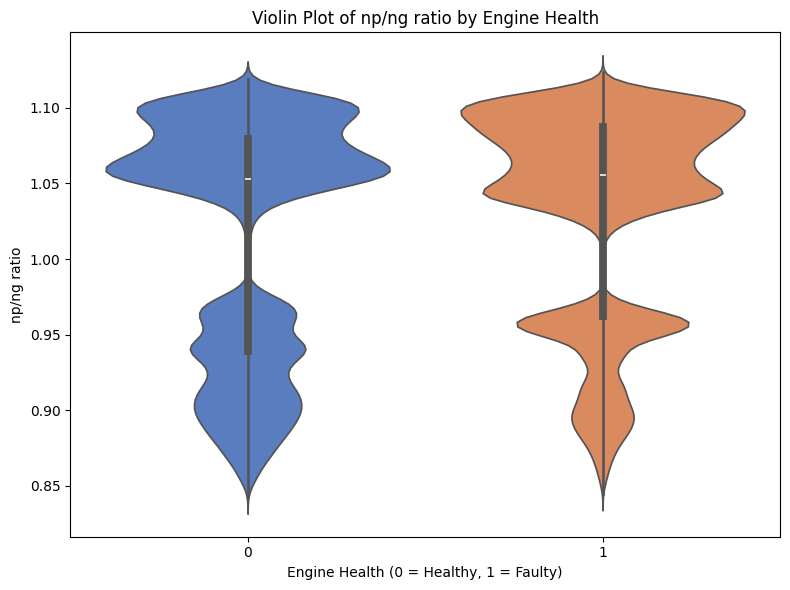

In [7]:
# VIOLIN PLOTS

# Violin Plot Torque Measured
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='trq_measured', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Torque Measured')
plt.title('Violin Plot of Torque Measured by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_trqmeasured.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Outside Air Temperature
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='oat', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Outside Air Temprerature')
plt.title('Violin Plot of Outside Air Temperature by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_oat.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Mean Gas Temperature
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='mgt', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Mean Gas Temperature')
plt.title('Violin Plot of Mean Gas Temperature by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_mgt.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Available Power
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='pa', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Available Power')
plt.title('Violin Plot of Available Power by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_pa.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Indicated Airspeed
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='ias', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Indicated Airspeed')
plt.title('Violin Plot of Indicated Airspeed by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_ias.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Net Power
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='np', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Net Power')
plt.title('Violin Plot of Net Power by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_np.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Compressor Speed
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='ng', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Compressor Speed')
plt.title('Violin Plot of Compressor Speed by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_ng.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Torque Margin
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='trq_margin', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Torque Margin')
plt.title('Violin Plot of Torque Margin by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_trqmargin.png')
plt.savefig(image_path)

plt.show()

# Violin Plot Torque Target
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='trq_target', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('Torque Target')
plt.title('Violin Plot of Torque Target by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_trqtarget.png')
plt.savefig(image_path)

plt.show()

# Violin Plot ΔT_relative
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='delta_T_relative', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('ΔT_relative')
plt.title('Violin Plot of ΔT_relative by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_deltaTrelative.png')
plt.savefig(image_path)

plt.show()

# Violin Plot ω
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='omega', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('ω')
plt.title('Violin Plot of ω by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_omega.png')
plt.savefig(image_path)

plt.show()

# Violin Plot np/ng ratio
plt.figure(figsize=(8,6))
sns.violinplot(data=merged_dataset, x='faulty', y='np_ng_ratio', palette='muted')

plt.xlabel('Engine Health (0 = Healthy, 1 = Faulty)')
plt.ylabel('np/ng ratio')
plt.title('Violin Plot of np/ng ratio by Engine Health')
plt.tight_layout()

image_path=os.path.join(feat_eng_path,'vp_npngratio.png')
plt.savefig(image_path)

plt.show()


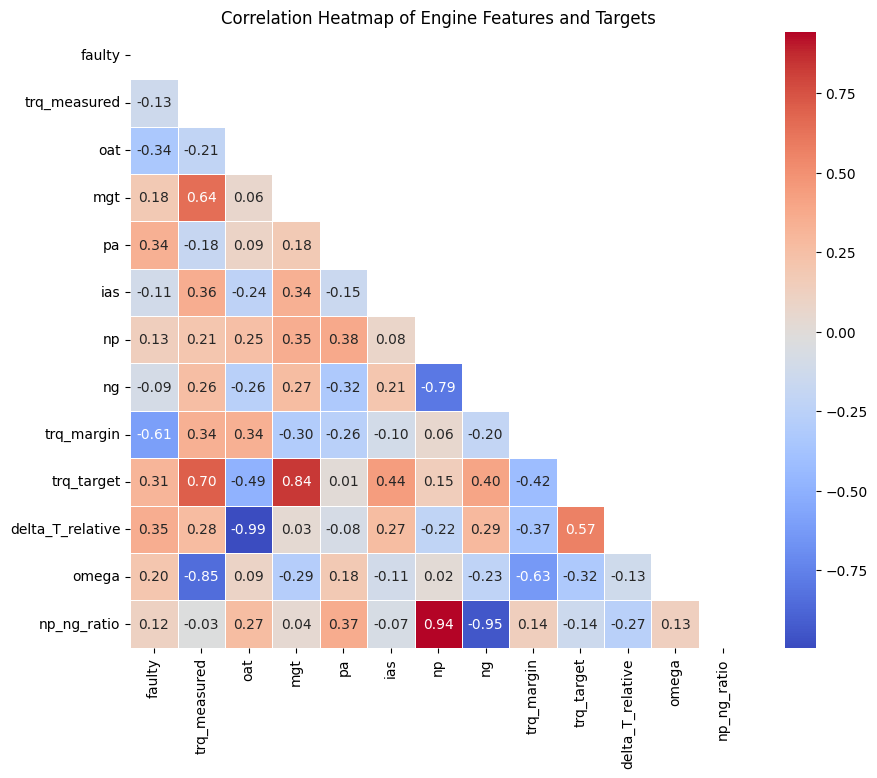

In [8]:
# MATRICE DI CORRELAZIONE

# Calcola la matrice di correlazione
correlation_matrix = merged_dataset.drop(columns=['id']).corr()

# Riordina le righe e le colonne per posizionare 'faulty' in cima
cols = ['faulty'] + [col for col in correlation_matrix.columns if col != 'faulty']
correlation_matrix = correlation_matrix[cols].reindex(cols)

# Creazione di una maschera per mostrare solo metà della matrice
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crea la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Heatmap of Engine Features and Targets')

image_path=os.path.join(feat_eng_path,'correlation_heatmap.png')
plt.savefig(image_path)

plt.show()

In [9]:
# RESAMPLE

# Contiamo le istanze per ciascuna classe
class_counts = merged_dataset['faulty'].value_counts()
print("Distribuzione iniziale delle classi:\n", class_counts)

# Separiamo le due classi
df_majority = merged_dataset[merged_dataset['faulty'] == 0]  # Classe sana (healthy)
df_minority = merged_dataset[merged_dataset['faulty'] == 1]  # Classe guasta (faulty)

# Determiniamo il numero massimo da raggiungere per bilanciare
n_samples = max(len(df_majority), len(df_minority))

# Eseguiamo il campionamento con rimpiazzo (bootstrap)
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=n_samples,  # Portiamo la minoranza allo stesso numero della maggioranza
                                 random_state=42)

# Combiniamo il dataset upsampled con la maggioranza
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Assegnazione dei pesi inversamente proporzionali alla classe (downweight)
df_balanced['weights'] = df_balanced['faulty'].apply(lambda x: 1.0 / class_counts[x])

# Shuffle del dataset per evitare bias
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Controlliamo la nuova distribuzione
print("Distribuzione dopo bilanciamento:\n", df_balanced['faulty'].value_counts())

# Verifica della media dei pesi
print("Media dei pesi per classe:\n", df_balanced.groupby('faulty')['weights'].mean())

merged_dataset = df_balanced

Distribuzione iniziale delle classi:
 faulty
0    443207
1    299418
Name: count, dtype: int64
Distribuzione dopo bilanciamento:
 faulty
1    443207
0    443207
Name: count, dtype: int64
Media dei pesi per classe:
 faulty
0    0.000002
1    0.000003
Name: weights, dtype: float64


Distribuzione iniziale delle classi:
 faulty
1    443207
0    443207
Name: count, dtype: int64
Linear Regression Results:
MAE: 2.7096, RMSE: 3.3239, R2: 0.9483, MAPE: 4.13%



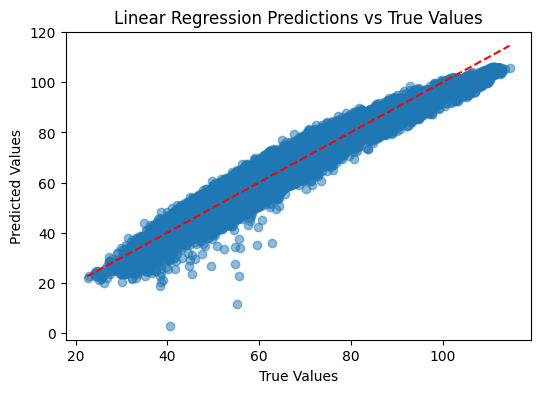

Random Forest Results:
MAE: 1.2710, RMSE: 1.7913, R2: 0.9850, MAPE: 2.03%



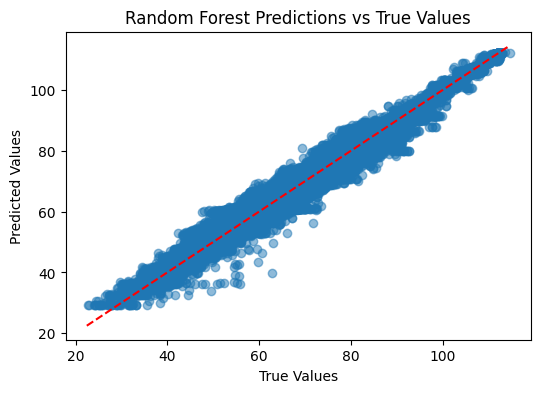

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:19:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
MAE: 0.7410, RMSE: 1.1034, R2: 0.9943, MAPE: 1.19%



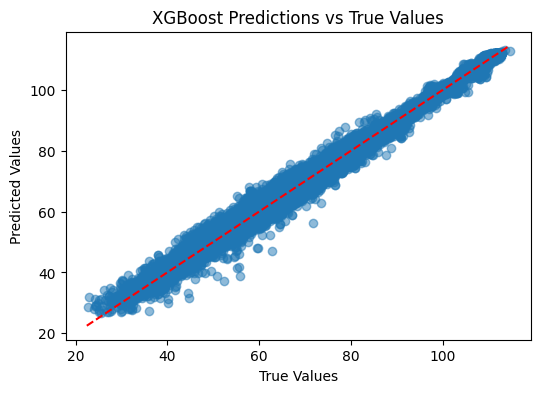

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 709131, number of used features: 5
[LightGBM] [Info] Start training from score 67.592473


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
MAE: 1.3780, RMSE: 1.8486, R2: 0.9840, MAPE: 2.15%



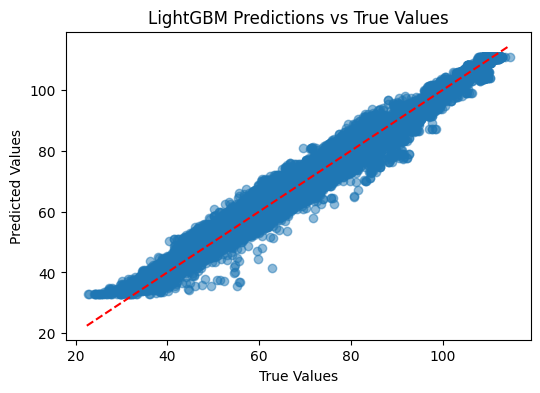


Confronto delle prestazioni:
                        MAE      RMSE        R2  MAPE (%)
Linear Regression  2.709558  3.323883  0.948330  4.130743
Random Forest      1.270990  1.791347  0.984993  2.025313
XGBoost            0.740955  1.103416  0.994306  1.185288
LightGBM           1.377969  1.848608  0.984018  2.147599


In [10]:
# REGRESSIONE

class_counts = merged_dataset['faulty'].value_counts()
print("Distribuzione iniziale delle classi:\n", class_counts)

# Selezione delle feature e target
features = ['trq_measured', 'ias', 'ng', 'delta_T_relative', 'np']
target = 'trq_target'

X = merged_dataset[features]
y = merged_dataset[target]

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizzazione delle feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Definizione dei modelli
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth = 10, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=50, device='cuda', max_depth = 10, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=50, boosting_type='gbdt', max_depth = 10, device='cpu', random_state=42)
}

# Addestramento e valutazione dei modelli
results = {}
all_residuals = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE (%)": mape}

    residuals = y_test - y_pred
    all_residuals[name] = residuals

    print(f"{name} Results:")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%\n")

    # Visualizzazione della predizione vs valore reale
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Predictions vs True Values")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')  # Linea di riferimento
    fig_path = os.path.join(regression_path, f"{name.replace(' ', '_')}_scatter.png")
    plt.savefig(fig_path)
    plt.show()

# Confronto delle prestazioni
df_results = pd.DataFrame(results).T
df_results.to_csv(os.path.join(regression_path, "regression_metrics.csv"), index=True)
print("\nConfronto delle prestazioni:")
print(df_results)


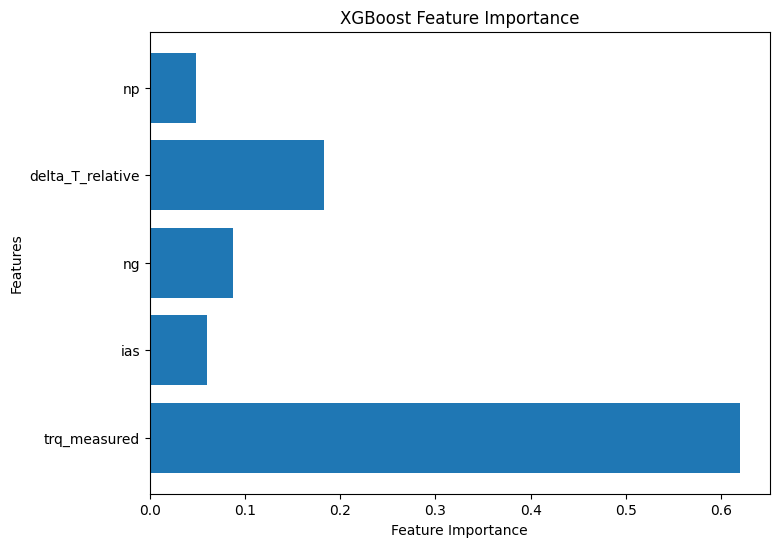

In [11]:
# IMPORTANZA FEATURES

importances = models["XGBoost"].feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()


🔍 Numero di valori NaN in 'trq_margin_pred': 0


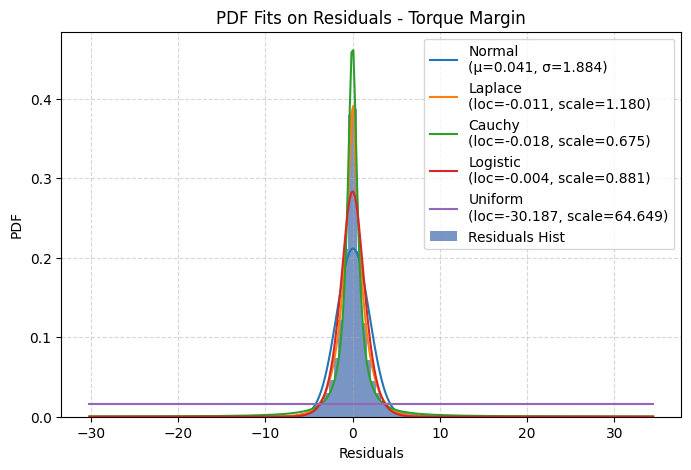


Risultati Test KS sulle distribuzioni fittate:
Normale: D = 0.1146, p-value = 0.0000
Laplace: D = 0.0247, p-value = 0.0000
Cauchy: D = 0.0343, p-value = 0.0000
Logistic: D = 0.0608, p-value = 0.0000
Uniforme: D = 0.4448, p-value = 0.0000


In [12]:
# CALCOLO TORQUE MARGIN E PDF

# Calcolo del torque margin utilizzando il torque target predetto
y_pred_trq_target = models["XGBoost"].predict(X_test_scaled)
trq_measured = merged_dataset.loc[X_test.index, 'trq_measured']

# Formula per il Torque Margin
trq_margin_pred = 100 * (trq_measured - y_pred_trq_target) / y_pred_trq_target

# Inserimento del torque margin predetto nel dataset
merged_dataset = merged_dataset.reindex(X_test.index)
merged_dataset['trq_margin_pred'] = trq_margin_pred

nan_count = merged_dataset['trq_margin_pred'].isna().sum()
print(f"\U0001F50D Numero di valori NaN in 'trq_margin_pred': {nan_count}")

# Calcoliamo i residui del torque margin
trq_margin_real = merged_dataset.loc[X_test.index, 'trq_margin']
residuals_trq_margin = trq_margin_real - trq_margin_pred

# Funzione per il fit delle distribuzioni e plot della PDF
def compare_pdf_fits(residuals, model_name):
    normal_params = norm.fit(residuals)
    laplace_params = laplace.fit(residuals)
    cauchy_params = cauchy.fit(residuals)
    logistic_params = logistic.fit(residuals)
    uniform_params = uniform.fit(residuals)

    x_vals = np.linspace(residuals.min(), residuals.max(), 300)

    normal_pdf = norm.pdf(x_vals, *normal_params)
    laplace_pdf = laplace.pdf(x_vals, *laplace_params)
    cauchy_pdf = cauchy.pdf(x_vals, *cauchy_params)
    logistic_pdf = logistic.pdf(x_vals, *logistic_params)
    uniform_pdf = uniform.pdf(x_vals, *uniform_params)

    plt.figure(figsize=(8, 5))
    plt.title(f"PDF Fits on Residuals - {model_name}")
    plt.plot(x_vals, normal_pdf, label=f"Normal\n(μ={normal_params[0]:.3f}, σ={normal_params[1]:.3f})")
    plt.plot(x_vals, laplace_pdf, label=f"Laplace\n(loc={laplace_params[0]:.3f}, scale={laplace_params[1]:.3f})")
    plt.plot(x_vals, cauchy_pdf, label=f"Cauchy\n(loc={cauchy_params[0]:.3f}, scale={cauchy_params[1]:.3f})")
    plt.plot(x_vals, logistic_pdf, label=f"Logistic\n(loc={logistic_params[0]:.3f}, scale={logistic_params[1]:.3f})")
    plt.plot(x_vals, uniform_pdf, label=f"Uniform\n(loc={uniform_params[0]:.3f}, scale={uniform_params[1]:.3f})")
    plt.hist(residuals, bins=120, density=True, alpha=0.75, color='#4C72B0', label="Residuals Hist")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("Residuals")
    plt.ylabel("PDF")

    # Salva la figura
    fig_path = os.path.join(regression_path, f"pdf_fits.png")
    plt.savefig(fig_path)

    plt.show()

# Funzione per eseguire il test KS sulle distribuzioni fittate
def ks_test_fitted_distributions(residuals):
    normal_params = norm.fit(residuals)
    laplace_params = laplace.fit(residuals)
    cauchy_params = cauchy.fit(residuals)
    logistic_params = logistic.fit(residuals)
    uniform_params = uniform.fit(residuals)

    fitted_distributions = {
        "Normale": (norm, normal_params),
        "Laplace": (laplace, laplace_params),
        "Cauchy": (cauchy, cauchy_params),
        "Logistic": (logistic, logistic_params),
        "Uniforme": (uniform, uniform_params)
    }

    ks_results = {}
    for name, (dist, params) in fitted_distributions.items():
        D, p_value = ks_1samp(residuals, lambda x: dist.cdf(x, *params))
        ks_results[name] = {"D-statistic": D, "p-value": p_value}

    print("\nRisultati Test KS sulle distribuzioni fittate:")
    for name, result in ks_results.items():
        print(f"{name}: D = {result['D-statistic']:.4f}, p-value = {result['p-value']:.4f}")

    # Salva in CSV
    df_ks = pd.DataFrame.from_dict(ks_results, orient="index")
    df_ks.to_csv(os.path.join(regression_path, "ks_test_results.csv"))

# Eseguiamo il fit delle distribuzioni e test KS sui residui del Torque Margin
compare_pdf_fits(residuals_trq_margin, "Torque Margin")
ks_test_fitted_distributions(residuals_trq_margin)

In [13]:
# SETTING CLASSIFICAZIONE


# **Verifica se la GPU è disponibile**
use_gpu = torch.cuda.is_available()
print(f"GPU disponibile: {use_gpu}")

# **Selezione delle feature per la classificazione**
features = ['trq_margin_pred', 'pa', 'trq_target', 'delta_T_relative', 'omega', 'np_ng_ratio']
target = 'faulty'

X = merged_dataset[features]
y = merged_dataset[target]

# **Suddivisione in Training e Test Set**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **Standardizzazione delle feature con dtype compatibile con GPU**
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# **Definizione dei modelli di base**
base_models = [
    ('RandomForest', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)),
    ('AdaBoost', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),n_estimators=50, random_state=42)),
    ('SVC', SVC(probability=True, kernel='rbf', C=1, random_state=42, cache_size=7000, verbose=True)),
    ('XGBoost', XGBClassifier(n_estimators=50, device='cuda' if use_gpu else 'hist',
                              max_depth=5, eval_metric='logloss', random_state=42))
]

# **Modello meta-classificatore: Logistic Regression**
meta_model = LogisticRegression(max_iter=500)

# **Creazione dello Stacking Classifier**
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

GPU disponibile: True


In [14]:
# SETTING CLASSIFICAZIONE CON PESI


# Verifica se la GPU è disponibile
use_gpu = torch.cuda.is_available()
print(f"GPU disponibile: {use_gpu}")

# Selezione delle feature e target
features = ['trq_margin_pred', 'pa', 'trq_target', 'delta_T_relative', 'omega', 'np_ng_ratio']
target = 'faulty'

X = merged_dataset[features]
y = merged_dataset[target]

# Suddivisione in Training e Test Set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype('float32')
X_test_scaled = scaler.transform(X_test).astype('float32')

# Definizione dei modelli di base con class weights
base_models = [
    ('RandomForest', RandomForestClassifier(
        n_estimators=50, max_depth=5, random_state=42,
        class_weight={0:1, 1:3}  # Penalizza di più la classe 1
    )),
    ('AdaBoost', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=5, class_weight={0:1, 1:3}),
        n_estimators=50, random_state=42
    )),
    ('SVC', SVC(
        probability=True, kernel='rbf', C=1, random_state=42,
        cache_size=7000, verbose=True,
        class_weight={0:1, 1:3}  # Penalizza la classe 1
    )),
    ('XGBoost', XGBClassifier(
        n_estimators=50,
        device='cuda' if use_gpu else 'cpu',  # Usa GPU se disponibile
        max_depth=5, eval_metric='logloss', random_state=42,
        scale_pos_weight=3  # Penalizza la classe 1
    ))
]

# Modello meta-classificatore con class weight
meta_model = LogisticRegression(
    max_iter=500,
    class_weight={0:1, 1:3}  # Penalizza maggiormente la classe 1
)

# Creazione dello Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

GPU disponibile: True


In [15]:
# ADDESTRAMENTO CLASSIFICAZIONE

# **Addestramento del modello ensemble**
stacking_clf.fit(X_train_scaled, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

StackingClassifier(cv=5,
                   estimators=[('RandomForest',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 3},
                                                       max_depth=5,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('AdaBoost',
                                AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                                                  1: 3},
                                                                                    max_depth=5),
                                                   random_state=42)),
                               ('SVC',
                                SVC(C=1, cache_size=7000,
                                    class_weight={0: 1, 1: 3}, probability=True,
                                    random_state=42, v...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=50, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(class_weight={0: 1, 1: 3},
                                                      max_iter=500))


 Accuracy (modello caricato): 0.9773

Classification Report:
               precision    recall  f1-score   support

           0     0.9908    0.9633    0.9769     17674
           1     0.9645    0.9911    0.9776     17783

    accuracy                         0.9773     35457
   macro avg     0.9777    0.9772    0.9773     35457
weighted avg     0.9776    0.9773    0.9773     35457



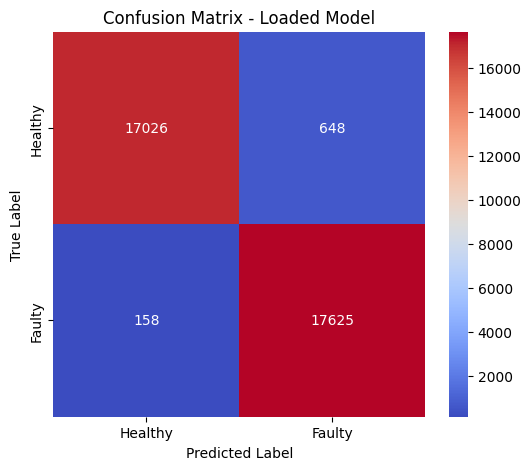


Esempio di prime 10 righe con Confidence Score:
   TrueLabel  PredictedLabel  ConfidenceScore
0          1               1         0.997986
1          0               0         0.993506
2          1               1         0.996048
3          0               0         0.987166
4          0               0         0.997656
5          0               0         0.996730
6          0               0         0.982116
7          0               1         0.982196
8          1               1         0.970675
9          1               1         0.995657
Falsi negativi totali: 158
Falsi negativi con confidenza > 0.7: 107 (67.72% dei FN)


In [16]:
# RISULTATI CLASSIFICAZIONE

# Predizione delle etichette
y_pred = stacking_clf.predict(X_test_scaled)

# Calcolo delle probabilità di ciascuna classe
y_proba = stacking_clf.predict_proba(X_test_scaled)

# Calcolo del confidence score
confidence_scores = []
for i in range(len(y_pred)):
    confidence_scores.append(y_proba[i, y_pred[i]])

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Accuracy (modello caricato): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Healthy", "Faulty"], yticklabels=["Healthy", "Faulty"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Loaded Model")
plt.show()

# Creazione DataFrame con confidence score
df_results = pd.DataFrame({
    'TrueLabel': y_test.values,
    'PredictedLabel': y_pred,
    'ConfidenceScore': confidence_scores
})

print("\nEsempio di prime 10 righe con Confidence Score:")
print(df_results.head(10))

# Grafico della confidence media per classe predetta
mean_conf = df_results.groupby('PredictedLabel')['ConfidenceScore'].mean().reset_index()


# Identifica i falsi negativi (FN)
#    FN: TrueLabel=1 (Faulty), PredictedLabel=0 (Healthy)
df_fn = df_results[
    (df_results['TrueLabel'] == 1) &
    (df_results['PredictedLabel'] == 0)
].copy()

# Seleziona quelli con ConfidenceScore > 0.7
df_fn_high_conf = df_fn[df_fn['ConfidenceScore'] > 0.7]

n_fn_total = len(df_fn)
n_fn_high_conf = len(df_fn_high_conf)

print(f"Falsi negativi totali: {n_fn_total}")
print(f"Falsi negativi con confidenza > 0.7: {n_fn_high_conf} "
      f"({n_fn_high_conf/n_fn_total*100:.2f}% dei FN)")

In [17]:
# SCORE CLASSIFICAZIONE


def custom_score_fn(true_label, pred_label, confidence):
    # check confidence to make sure it's between 0 and 1
    if (confidence < 0) or (confidence > 1):
        return -100

    # make sure that the pred_label is 0 or 1
    if pred_label not in [0, 1]:
        return -100

    # invert confidence if pred_label is incorrect
    if pred_label != true_label:
        confidence = -confidence

    # true state is healthy (0)
    if true_label == 0:
        score = confidence
    else:
        # true state is faulty (1)
        if confidence >= 0:
            score = confidence
        else:
            score = 4 * (confidence ** 11) + 1.0 * confidence

    return score


# Aggiungi una colonna "Score" calcolata riga per riga
df_results_with_score = df_results.copy()
df_results_with_score['Score'] = df_results_with_score.apply(
    lambda row: custom_score_fn(row['TrueLabel'], row['PredictedLabel'], row['ConfidenceScore']),
    axis=1
)

# Calcola lo score finale: ad esempio la media
final_score = df_results_with_score['Score'].mean()
print(f"Score finale medio sulla classificazione: {final_score:.4f}")

# Se invece vuoi la somma dei punteggi totali
total_score = df_results_with_score['Score'].sum()
print(f"Score totale sulla classificazione: {total_score:.4f}")

Score finale medio sulla classificazione: 0.9416
Score totale sulla classificazione: 33386.6660


In [19]:
# SAVE RESULTS

# ** Salvataggio del modello e dei risultati**
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"/content/drive/MyDrive/PHM2024/Output/Classification/model_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

# Salva il modello e lo scaler
#joblib.dump(stacking_clf, os.path.join(save_dir, "stacking_classifier.pkl"))
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))

# Salva le feature usate
features_info = {
    "features": features,
    "target": target
}
with open(os.path.join(save_dir, "features.json"), "w") as f:
    json.dump(features_info, f, indent=4)

# Salva i parametri dei modelli
model_config = {
    "RandomForest": base_models[0][1].get_params(),
    "AdaBoost": {
        "estimator": base_models[1][1].estimator.get_params(),  # Prendi solo i parametri dell'albero
        "n_estimators": base_models[1][1].n_estimators,
        "random_state": base_models[1][1].random_state
    },
    "SVC": base_models[2][1].get_params(),
    "XGBoost": base_models[3][1].get_params(),
    "MetaModel (LogisticRegression)": meta_model.get_params()
}

with open(os.path.join(save_dir, "model_config.json"), "w") as f:
    json.dump(model_config, f, indent=4)

# ** Genera e salva la matrice di confusione**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Healthy", "Faulty"], yticklabels=["Healthy", "Faulty"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Stacking Ensemble")
conf_matrix_path = os.path.join(save_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)  # Salva l'immagine
plt.close()  # Chiudi la figura per liberare memoria

# Salva i risultati in un file di testo
results_text = f"""
Risultati del modello salvato - {timestamp}

 Features usate: {features}
 Target: {target}
 Accuracy: {accuracy:.4f}

Classification Report:
{classification_report(y_test, y_pred)}

Falsi negativi totali: {n_fn_total}
Falsi negativi con confidenza > 0.7: {n_fn_high_conf}
{n_fn_high_conf/n_fn_total*100:.2f}% dei FN

Score medio: {final_score:.4f}
Score totale: {total_score:.4f}
"""

with open(os.path.join(save_dir, "results.txt"), "w") as f:
    f.write(results_text)

# Salva il DataFrame con TrueLabel, PredictedLabel, ConfidenceScore
df_results_path = os.path.join(save_dir, "classification_results.csv")
df_results.to_csv(df_results_path, index=False)

# Salva il DataFrame aggiornato (con la colonna Score)
df_results_path_with_score = os.path.join(save_dir, "classification_results_with_score.csv")
df_results_with_score.to_csv(df_results_path_with_score, index=False)

print(f"\n Modello e risultati salvati in: {save_dir}")


 Modello e risultati salvati in: /content/drive/MyDrive/PHM2024/Output/Classification/model_20250429_143609
